In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the dataset

In [ ]:
import urllib.request as req
from urllib.parse import urlparse
import os
import progressbar
import zipfile
import gzip
import shutil
import json
import pandas as pd
import re
import string
import imblearn

pbar = None


def show_progress(block_num, block_size, total_size):
    global pbar
    if pbar is None:
        pbar = progressbar.ProgressBar(maxval=total_size)
        pbar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(downloaded)
    else:
        pbar.finish()
        pbar = None

def wget(url):
    a = urlparse(url)
    filename = os.path.basename(a.path)
    if not os.path.isfile(filename):
        req.urlretrieve(url, filename, show_progress)
        print(f'downloaded to {filename}')
    else:
        print(f'file {filename} has already been downloaded')
    return filename

def unzip(filename, directory_to_extract_to=os.getcwd()):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)
        print(f'extraction done {zip_ref.namelist()}')

def gunzip(gzfile, fout):
    with gzip.open(gzfile, 'rb') as f_in:
        with open(fout, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f'{gzfile} extracted to {fout}')


# map punctuation to space
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) 

def text_preprocessing(df):
    """
    Preprocess the text for better understanding
    
    """
    # trim the whitespace at the edges of the string
    df['reviewText'] = df['reviewText'].str.strip()

    # lowercase the text in the string
    df['reviewText'] = df['reviewText'].str.lower()

    # replace new line with a .

    df['reviewText'] = df['reviewText'].replace('\n', ' . ')

    return df


filename = wget("https://nlp.stanford.edu/data/glove.6B.zip")
unzip(filename)
Video_Games_5 = wget('http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz')
df = pd.read_json("./Video_Games_5.json.gz", lines=True, compression='gzip')
df = df[['reviewText', 'overall']]
df = text_preprocessing(df)
df = df.dropna()
df = df.drop_duplicates()
print(df.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
100% (862182613 of 862182613) |##########| Elapsed Time: 0:02:44 Time:  0:02:44


downloaded to glove.6B.zip
extraction done ['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt']


100% (154050105 of 154050105) |##########| Elapsed Time: 0:00:04 Time:  0:00:04


downloaded to Video_Games_5.json.gz
(398889, 1)


,reviewText
0,"this game is a bit hard to get the hang of, bu..."
1,i played it a while but it was alright. the st...
2,ok game.
3,"found the game a bit too complicated, not what..."
4,"great game, i love it and have played it since..."


## Taking a sample

Just taking a sample where the where the number of sentences is only 1. That is just a small sample of the total

In [ ]:
print('all sentences', len(df))
total_df = df
df = df[df.reviewText.str.split('.').str.len()==1]
df = df[df.reviewText.str.split('!').str.len()==1]
df = df[df.reviewText.str.split('\n').str.len()==1]
print('only single sentences', len(df))
df = df.drop_duplicates()
print('after removing the duplicates', len(df))

all sentences 398889
only single sentences 37137
after removing the duplicates 37137


## Convert to vectors

In order to process the textual data using clustering algorithms, they need to be converted to vectors. Universal Sentence Encoder is a great model to get the vectors as the models are finetuned using STS benchmarking

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

def get_embeddings(text):
    if not isinstance(text, list):
        text = [text]
    return embed(text)

embs = get_embeddings('The quick brown fox jumps over the lazy dog.')
print(embs.shape)

(1, 512)


In [ ]:
from tqdm import tqdm, trange
import numpy as np
import math

def run_get_embeddings(df, chunk_size=100):
    sentences = df.reviewText.values.tolist()
    total_size = len(df)
    n_chunks = math.ceil(total_size/chunk_size)
    embeddings_list = []

    for start in trange(n_chunks):
        start = start * chunk_size
        stop = start + chunk_size
        embeddings = embed(sentences[start:stop])
        embeddings_list.append(embeddings)
        # print(embeddings.shape)

    # flatten
    embeddings_list0 = embeddings_list[:-1]
    embeddings_list1 = embeddings_list[-1]
    embeddings_list0 = np.array(embeddings_list0)
    embeddings_list0 = embeddings_list0.reshape(-1, embeddings_list0.shape[-1])
    embeddings_list = np.concatenate((embeddings_list0, embeddings_list1), axis=0)
    return embeddings_list


df['embs'] = list(run_get_embeddings(df))

100%|██████████| 372/372 [01:01<00:00,  6.05it/s]


In [ ]:
import numpy as np

embs = df.embs
embs = np.vstack(embs)
print(embs.shape)

(37137, 512)


In [ ]:
np.savez('/content/drive/MyDrive/embs.npz', embs=embs)

In [ ]:
import numpy as np

npz = np.load('/content/drive/MyDrive/embs.npz')
embs = npz['embs']
print(embs.shape)

(37137, 512)


In [ ]:
df['embs'] = list(embs)

## Dimensionality Reduction

In [ ]:
from sklearn.decomposition import PCA

# using PCA to reduce the dimensionality
pca = PCA(n_components=10, whiten=False, random_state=42)
abstracts_pca = pca.fit_transform(embs)
print(abstracts_pca.shape)

(37137, 10)


In [ ]:
df['pca'] = list(abstracts_pca)

## Kmeans

In [ ]:
!pip install -U yellowbrick

     |████████████████████████████████| 271 kB 5.1 MB/s 
  Attempting uninstall: yellowbrick
    Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


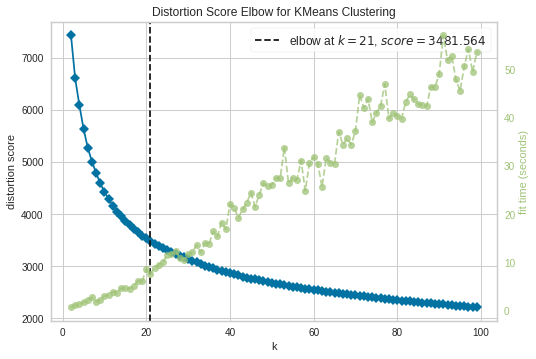

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d30d1a890>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=99,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto', random_state=42,
                                  tol=0.0001, verbose=0),
                 k=None, locate_elbow=True, metric='distortion', timings=True)

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

# Use the quick method and immediately show the figure
kelbow_visualizer(KMeans(random_state=42), abstracts_pca, k=(2,100))

100%|██████████| 10/10 [03:58<00:00, 23.88s/it]


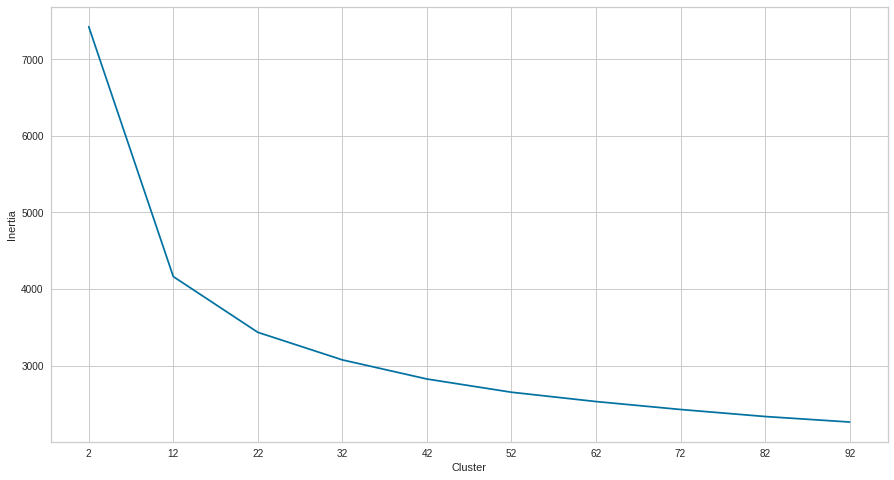

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

def elbow_plot(range_, data, figsize=(15,8)):
    '''
    elbow plot function to help find the right amount of clusters for a dataset
    '''
    inertia_list = []
    range_ = list(range_)
    for n in tqdm(range_):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        inertia_list.append(kmeans.inertia_)
        
    # plotting
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.lineplot(y=inertia_list, x=range_, ax=ax)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Inertia")
    ax.set_xticks(list(range_))
    fig.show()
    fig.savefig("elbow_plot.png")

elbow_plot(range(2, 100, 10), abstracts_pca)

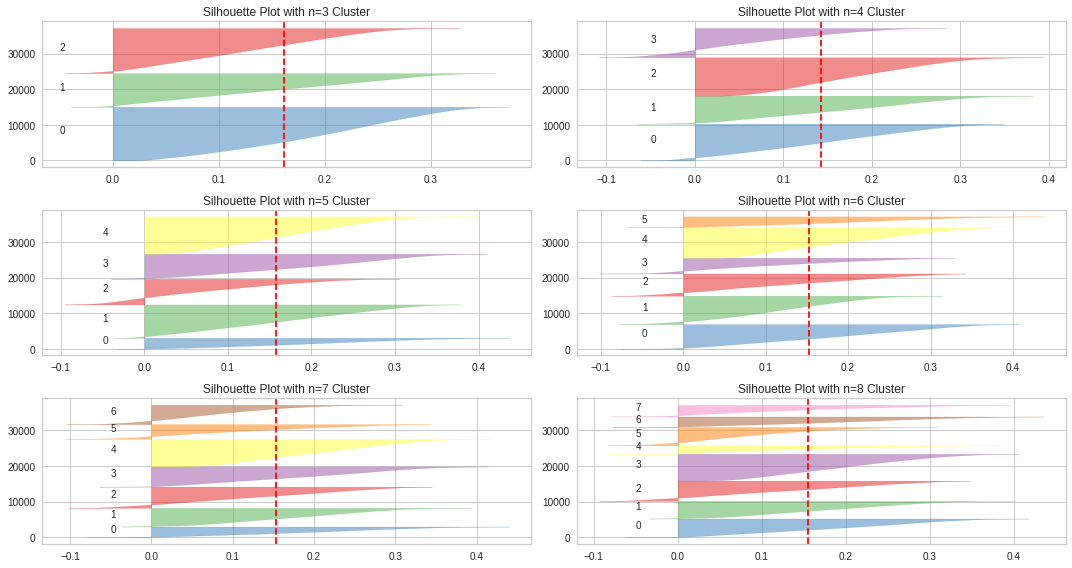

In [ ]:
from sklearn.preprocessing import StandardScaler as SS
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer

def silhouettePlot(range_, data, figsize=(15,8)):
    '''
    we will use this function to plot a silhouette plot that helps us to evaluate the cohesion in clusters (k-means only)
    '''
    half_length = int(len(range_)/2)
    range_list = list(range_)
    fig, ax = plt.subplots(half_length, 2, figsize=figsize)
    for _ in range_:
        kmeans = KMeans(n_clusters=_, random_state=42)
        q, mod = divmod(_ - range_list[0], 2)
        sv = SilhouetteVisualizer(kmeans, colors="yellowbrick", ax=ax[q][mod])
        ax[q][mod].set_title("Silhouette Plot with n={} Cluster".format(_))
        sv.fit(data)
    fig.tight_layout()
    fig.show()
    fig.savefig("silhouette_plot.png")

silhouettePlot(range(3,9), abstracts_pca)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=42)
kmeans_labels = kmeans.fit_predict(abstracts_pca)
df["cluster"] = kmeans_labels

## the clusters

In [ ]:
df.cluster.value_counts()

1     2998
3     2864
19    2690
15    2306
0     2203
9     2182
14    2114
2     1829
17    1776
18    1664
5     1642
4     1549
8     1519
10    1513
11    1489
16    1459
12    1458
6     1428
7     1381
13    1073
Name: cluster, dtype: int64

In [ ]:
def list_labels(df, cluster_labels, column, sample_limit=10):
    for label in list(np.unique(cluster_labels))[1:]:
        print(f'printing for label={label}')
        label_df = df[df[column]==label][['reviewText']]
        sample_count = len(label_df)
        if sample_count > sample_limit:
            sample_count = sample_limit
        for _, row in label_df.sample(sample_count).iterrows():
            print(row['reviewText'])
        print('%'*10)

list_labels(df, kmeans_labels, 'cluster')

printing for label=1
easy to apply to xbox account
great controller but battery die in 24 hrs where as dualshock 3 ps3 controller  last 5-6 days
its a really functional and good charger for a remote wii controllers, i recomended it 100% , it's really beautiful too
works just fine for my sons wii u
i love the av video tv cable
matches my peach remote
bought this long ago forgot to make a review it makes my ps vita looks blue as if its blue also protects gives it a unique color blue mixed with black looks really good
good case my son still uses it, it fits both of his ds
good price  bands are new  revived dvd player
works great in our ps2 slim
%%%%%%%%%%
printing for label=2
seems a fun game
fantastic videogame
great game but took way too long to make;;;
great game, amazing songs
love the game, great grafics
awesome game and works great
great game from where the first one ended
excellent item, very good game
welcome to the best game in the world
awesome fps game
%%%%%%%%%%
printing for l

## DBSCAN

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def findOptimalEps(n_neighbors, data):
    '''
    function to find optimal eps distance when using DBSCAN
    reference: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
    '''
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

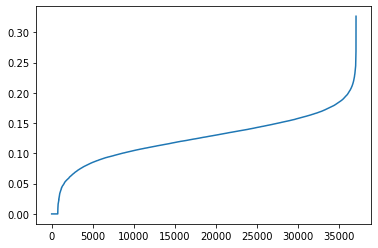

In [ ]:
findOptimalEps(5, abstracts_pca)

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.15, min_samples=5, metric="cosine")
dbscan_labels = dbscan.fit_predict(embs)
df["dbscan_labels"] = dbscan_labels

In [ ]:
df.dbscan_labels.value_counts()

-1      29877
 0       2933
 3        435
 1        367
 16       352
        ...  
 214        4
 90         4
 235        3
 86         2
 103        2
Name: dbscan_labels, Length: 243, dtype: int64

In [ ]:
list_labels(df, dbscan_labels, 'dbscan_labels')

printing for label=0
my son enjoy this game
a really good video game
son enjoys it
tough but fun
another game my son loves
wife like it
love this game  - have played it many times and have enjoyed it each time -
i love this game so much,
son liked the game
amazing game so fun to play
%%%%%%%%%%
printing for label=1
amazing amazing amazing
it is alright
its fine
ok good
perfect no problems
grat
perfect;
very nice
it's ok i guess
everything great
%%%%%%%%%%
printing for label=2
i'm satisfied with my purchase
:) happy with my purchase
extremely happy with purchase
i am satisfied with purchase
pleased with purchase
i am very happy with this purchase
very pleased with purchase
very happy with purchase
happy with the purchase
happy with purchase
%%%%%%%%%%
printing for label=3
works okay
great prices and products a +++++++
works just fine and at a nice price
it works great, i love it
very good product
worked okay
it's works good
worked very well
works great
great  product
%%%%%%%%%%
printing

## select the clusters

Based on the data, since we do not have the labels predefined to us we can consider 3 labels which are "thumps up", "neutral", "thumbs down". There will also be an UNK label that will just act as a dump for sentences where the model is not very sure.

Went through the data and added the clusters below for the labels

In [ ]:
import pandas as pd

thumbs_up_clusters = [58, 53, 51, 46, 43, 40, 39, 38, 37, 36, 35, 31, 30, 28, 27, 25, 22, 21, 18, 15, 8, 7]
thumbs_down_clusters = [55, 45, 44, 42, 34, 23, 20, ]
neutral_clusters = [56, 47, 52, 50, 49, 48, 33, 32, 24, ]
unknown_clusters = [6, 5, 3, 1]

def get_labels(dic, clusters, label):
    for cluster in clusters:
        dic[cluster] = label

cluster_label_defined_label_mapping = {}
get_labels(cluster_label_defined_label_mapping, thumbs_up_clusters, 'up')
get_labels(cluster_label_defined_label_mapping, thumbs_down_clusters, 'down')
get_labels(cluster_label_defined_label_mapping, neutral_clusters, 'neutral')
get_labels(cluster_label_defined_label_mapping, unknown_clusters, 'UNK')
# print(cluster_label_defined_label_mapping)

def create_training(df):
    training_df = pd.DataFrame(columns=['reviewText', 'label'])
    for cluster_id in list(np.unique(dbscan_labels)):
        cluster_label = cluster_label_defined_label_mapping.get(cluster_id)
        if cluster_label:
            cluster_df = df[df.dbscan_labels==cluster_id][['reviewText']]
            cluster_df['label'] = cluster_label
            training_df = training_df.append(cluster_df, ignore_index=True)
    return training_df

training_df = create_training(df)
training_df.sample(5)

,reviewText,label
1562,the paper mario color splash video game for th...,neutral
87,really good,UNK
1521,"fast shipping, product as described",neutral
1345,worth it :),up
154,it's just ok,UNK


In [ ]:
training_df.sample(10)

,reviewText,label
1410,arrived in awsome condition worked perfect,up
288,bery good,UNK
554,"no complaints, works good",UNK
1804,great gift idea,down
1585,much nostalgia,up
1696,just what we needed,neutral
1190,absolute classic,down
1471,it was awesome,up
538,"works great,",UNK
1622,worked as stated,up


In [ ]:
training_df.label.value_counts()

UNK        1107
up          530
down        106
neutral      94
Name: label, dtype: int64

## feed into the model and train

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(training_df, test_size=0.3, stratify=training_df.label, random_state=42)

X_train = df_train['reviewText']
y_train = df_train['label']

X_test = df_test['reviewText']
y_test = df_test['label']

print(len(df_train), len(df_test))

1285 552


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, matthews_corrcoef
from imblearn.metrics import classification_report_imbalanced

vectorizer = CountVectorizer(stop_words=['elder scroll','halo'])
X_train_title_vec = vectorizer.fit_transform(X_train)
X_test_title_vec = vectorizer.transform(X_test)

X_resampled, y_resampled = RandomOverSampler().fit_resample(X_train_title_vec, y_train)
print(sorted(Counter(y_resampled).items()))

# for alpha in np.linspace(0,2,20)[1:]:
model = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test_title_vec)

print('accuracy:', accuracy_score(df_test['label'], y_pred))
print('matthews_corrcoef:', matthews_corrcoef(df_test['label'], y_pred))
print('classification_report:\n', classification_report_imbalanced(df_test['label'], y_pred))

[('UNK', 774), ('down', 774), ('neutral', 774), ('up', 774)]
accuracy: 0.8188405797101449
matthews_corrcoef: 0.6822727305203509
classification_report:
                    pre       rec       spe        f1       geo       iba       sup

        UNK       0.86      0.86      0.79      0.86      0.82      0.68       333
       down       0.37      0.78      0.92      0.50      0.85      0.71        32
    neutral       0.93      0.89      1.00      0.91      0.94      0.88        28
         up       0.93      0.72      0.98      0.81      0.84      0.68       159

avg / total       0.86      0.82      0.86      0.83      0.84      0.70       552



/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['elder', 'scroll'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# inference and evaluate

In [ ]:
df.sample(10)

,reviewText,pca,cluster,dbscan_labels,embs,prediction
462661,awesome game just short,"[-0.24192375, 0.37090215, 0.035618532, -0.1210...",2,173,"[-0.044652827, -0.018463878, -0.057536952, 0.0...",down
335203,this is a great game,"[-0.3259211, 0.45180982, 0.07431602, -0.032697...",2,0,"[-0.02750199, -0.02810393, 0.030478979, 0.0865...",down
340515,"amazing game, just got the platinum trophy few...","[-0.3684325, 0.07659722, 0.09387075, -0.023885...",17,-1,"[-0.044170685, 0.0355655, 0.028191466, -0.0214...",up
326796,great system just what i was looking for great...,"[0.12719862, -0.06839018, 0.27930105, -0.02705...",18,-1,"[0.01810671, -0.04275435, 0.00011063203, -0.03...",UNK
50389,greaf,"[0.3020989, 0.056579642, -0.34315073, 0.039301...",0,-1,"[-0.043588914, 0.049765706, -0.040406995, 0.02...",UNK
129101,just like the ones that come with the wii,"[0.06455647, -0.33380944, -0.06144933, 0.01821...",1,-1,"[0.060925286, 0.020873459, -0.044746365, 0.030...",neutral
301279,great game and love how now ps3 fans can have ...,"[-0.27141935, -0.07372469, 0.027057923, -0.040...",19,-1,"[0.053259496, -0.0042992365, 0.030375196, 0.04...",up
460007,awesome couldn't find this anywhere else,"[0.20196186, 0.073376305, 0.08308276, 0.140363...",13,-1,"[-0.032618485, 0.039028592, -0.027494771, 0.03...",down
321591,"its a cable, as long as it keeps working i am ...","[0.19014363, -0.3267236, 0.13686098, 0.1205121...",18,-1,"[0.018336453, 0.03411002, 0.016387794, -0.0008...",UNK
496287,the best product,"[0.32054895, 0.17416458, -0.01067513, -0.12013...",8,3,"[0.04138812, 0.02892488, 0.052284703, -0.01270...",up


In [ ]:
prediction_vec = vectorizer.transform(df.reviewText)
y_pred = model.predict(prediction_vec)

In [ ]:
df['prediction'] = y_pred

In [ ]:
df.prediction.value_counts()

up         18386
UNK        11350
down        4460
neutral     2941
Name: prediction, dtype: int64

In [ ]:
df[df.prediction=='up'].sample(10, random_state=42)

,reviewText,pca,cluster,dbscan_labels,embs,prediction
329182,the wiifit metter is the perfect gadget to wii...,"[-0.00199001, -0.3476976, -0.09281697, 0.02093...",1,-1,"[0.063482665, 0.04491554, 0.062078793, 0.08404...",up
292884,wish the battery life was better,"[0.09393195, -0.10710362, 0.008039174, 0.00842...",9,-1,"[0.014792965, 0.10218941, 0.09832599, 0.005235...",up
306784,better on xbox 360,"[0.004541137, -0.08075055, -0.13412157, -0.142...",1,-1,"[0.025156539, 0.001736207, 0.06450222, -0.0381...",up
421330,don't care much for the game but dragon ball z...,"[-0.15484723, -0.17359401, -0.16218312, -0.046...",3,-1,"[-0.025949636, 0.08195375, 0.08545554, 0.00559...",up
269426,"well, it was a ltitle hard to set up if you're...","[0.041860547, -0.33342856, 0.043002278, -0.099...",1,-1,"[-0.001936791, -0.016240025, 0.03231991, 0.027...",up
459748,10 out of 10 for the video game 3 out of 5 sta...,"[-0.16411123, -0.18381877, 0.047492534, -0.026...",15,-1,"[-0.07006707, 0.01636874, 0.031449657, 0.04958...",up
242198,my son likes the game almost beat it won't be ...,"[-0.25408122, 0.06378476, 0.1296545, 0.3432094...",12,-1,"[0.0058709886, -0.0039439006, 0.029598664, 0.0...",up
54604,awesome game i love this game its cool and if ...,"[-0.37400368, 0.05370344, 0.027259683, -0.0592...",19,-1,"[-0.074939266, -0.0018148309, 0.010837514, 0.0...",up
273483,"love the call of duty franchise, great game, i...","[-0.22834799, -0.06056286, -0.09766923, -0.121...",3,-1,"[-0.0030175636, -0.00088107993, 0.023291267, 0...",up
275835,she has an over the to shot which makes it har...,"[0.026121218, -0.100771025, -0.06573461, 0.021...",9,-1,"[-0.043773226, 0.040767327, -0.0014880068, -0....",up


In [ ]:
df[df.prediction=='neutral'].sample(10, random_state=42)

,reviewText,pca,cluster,dbscan_labels,embs,prediction
437572,"tedious, repetitive game","[-0.15096684, 0.18502195, -0.3183795, -0.04883...",11,-1,"[-0.01077282, -0.011082283, -0.030061262, 0.07...",neutral
171363,helped my console,"[0.19110596, -0.12501132, -0.035473906, 0.0280...",5,-1,"[-0.0076302434, -0.015660485, -0.013883037, 0....",neutral
442939,where are the uhd 4k rentals or digital purcha...,"[0.10407974, -0.25247383, -0.13490097, -0.0016...",9,-1,"[-0.010163973, 0.063187554, -0.02153756, 0.003...",neutral
31449,"fast shipping, great item","[0.27143466, 0.17429534, 0.31164017, -0.229263...",7,16,"[-0.017767755, 0.022290811, 0.07382946, 0.0567...",neutral
405062,amiibo was great and received fast,"[0.14185953, -0.08317757, 0.20342112, -0.06769...",7,-1,"[-0.0050937645, 0.026605016, 0.021809863, 0.06...",neutral
117414,arrived as described worked as advertised,"[0.2978187, -0.13614832, 0.23287293, -0.030188...",7,-1,"[-0.005521552, -0.0018539372, 0.03811145, 0.00...",neutral
446618,every single disney video game in existence fr...,"[-0.18946844, -0.07058693, -0.20213453, -0.150...",3,-1,"[-0.11753112, -0.022587128, 0.07582528, -0.025...",neutral
396352,grandson plays this a lot likes the sounds,"[-0.102021515, 0.07011255, 0.086474046, 0.5044...",16,-1,"[0.035800293, -0.0469931, 0.035666276, 0.04652...",neutral
71685,castlevania 2 simon's quest is the greatest vi...,"[-0.22216478, -0.09712472, -0.2221588, -0.1397...",3,-1,"[-0.062123153, -0.048710816, 0.015779383, 0.02...",neutral
395072,item as described fast shipping thank you,"[0.2575594, -0.010178714, 0.30930758, -0.06525...",7,-1,"[-0.013641965, -0.039457843, 0.09023652, 0.043...",neutral


In [ ]:
df[(df.prediction=='down')].sample(10, random_state=42)

,reviewText,pca,cluster,dbscan_labels,embs,prediction
47691,another game my son loves,"[-0.2930162, 0.17872089, -0.10589581, 0.402345...",12,0,"[-0.019721545, -0.042633887, -0.006188869, 0.0...",down
327112,worked perfectly and i could fit all fit games...,"[0.051930103, -0.3042956, 0.15160882, -0.10180...",5,-1,"[-0.012396457, 0.0131829865, -0.0059968308, 0....",down
305565,just what i needed worked perfectly,"[0.28643924, -0.12480521, 0.29397118, -0.01562...",4,95,"[0.024244454, -0.032864634, -0.009825901, -0.0...",down
475503,time travel game,"[-0.09614003, 0.12582147, -0.3190539, -0.05304...",11,-1,"[-0.0077857613, -0.0033060098, 0.032279525, -0...",down
346420,great addition to my xbox system,"[0.002448844, -0.10049043, 0.12928757, -0.0376...",1,-1,"[-0.006692405, -0.010060947, -0.0018219836, -0...",down
483754,"love this game,its good","[0.061703455, 0.34905282, 0.07738528, 0.084811...",13,-1,"[0.0066086226, -0.006356377, -0.011517454, 0.0...",down
483347,love this headset,"[0.059032433, -0.01662776, 0.03242759, -0.0340...",1,87,"[0.036604922, 0.05182866, -0.03903544, 0.05580...",down
257645,great graphics,"[0.012268196, 0.37618303, -0.06462567, -0.2375...",2,0,"[-0.04705903, -0.03822348, 0.06052468, 0.01050...",down
335929,ist a classic,"[0.21610196, 0.19714107, -0.23426634, 0.014692...",0,-1,"[0.009348232, -0.02942555, -0.03189832, -0.040...",down
210713,if you like hockey then grab this one,"[-0.12948388, 0.008940354, -0.043328058, 0.070...",19,-1,"[-0.059430804, -0.0070341695, 0.016846258, 0.0...",down


In [ ]:
df[(df.prediction=='UNK')].sample(10, random_state=42)

,reviewText,pca,cluster,dbscan_labels,embs,prediction
402652,works great but doesn't have the headset jack,"[0.114167444, -0.27313632, 0.18769167, -0.0793...",1,-1,"[-0.016928552, 0.09894081, -0.036616277, -0.02...",UNK
430194,sweet addition to infinity,"[0.23975359, 0.12745045, -0.12541564, -0.01546...",9,-1,"[-0.0783204, 0.016220571, -0.057169992, -0.002...",UNK
98578,"very good, thanks","[0.41520938, 0.33283204, 0.15244766, -0.067652...",10,5,"[-0.011692649, 0.016949167, 0.04413706, 0.0355...",UNK
110126,great deal for the price,"[0.2433152, 0.24010006, 0.24480498, -0.1204749...",8,4,"[0.04889063, 0.00097291905, 0.008084177, 0.037...",UNK
283925,never have i found a mouse that fitted me more...,"[0.1682346, -0.32216328, -0.008764557, -0.0087...",5,-1,"[0.019946402, -0.004987539, 0.07067245, -0.005...",UNK
419159,love it kick butt,"[0.20451085, 0.35841578, -0.02513092, 0.103056...",13,-1,"[-0.013956072, -0.002786458, -0.016278375, 0.0...",UNK
357489,worked amazingly,"[0.41563296, 0.13929531, 0.2139326, -0.1657039...",4,3,"[-0.005559459, -0.013689035, -0.0066558546, -0...",UNK
338714,"100% positive feedback, customer, excellent se...","[0.3176013, -0.11995228, 0.3156121, -0.1249151...",7,-1,"[-0.062256865, 0.016938716, 0.031341013, 0.011...",UNK
311360,i couldn't wait to play it,"[-0.18892364, 0.22773893, 0.035512168, 0.13337...",17,0,"[-0.056711465, 0.0072616795, 0.004306135, 0.06...",UNK
461881,chevre,"[0.2672007, 0.07540127, -0.3198549, 0.05612667...",0,-1,"[-0.082012236, -0.005367712, 0.0052556684, -0....",UNK


 Improving the labels. as part of the business process, based on user action, you can infer if the text classification was correct or not and then feed that back to the system . In this way you have a system that continually learns by itself.